In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv

import scanpy as sc
import scanpy.external as sce

from igraph import *
import ipywidgets
from MulticoreTSNE import MulticoreTSNE as TSNE #faster TSNE alternative
import anndata
from anndata import read_h5ad
import arrow
import bbknn
import leidenalg

sc.settings.verbosity = 3
sc.logging.print_versions()
np.random.seed(685)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.set_figure_params(dpi=50)

scanpy==1.4.5.dev147+g724da7d anndata==0.6.22.post2.dev80+g72c2bde numpy==1.17.3 scipy==1.3.1 pandas==0.25.2 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


# Case study: microglia

In [3]:
microglia_16_vs_101214 = pd.read_csv('./Fig4/facs.Brain_Myeloid.rank_genes_16vs101214.csv')
microglia_101214_vs_16 = pd.read_csv('./Fig4/facs.Brain_Myeloid.rank_genes_101214vs16.csv')

microglia_101214_vs_16.head()

,Unnamed: 0,score,logfoldchanges,pvals,pvals_adj
0,Ifitm3,15.427371,5.987740,8.986661e-42,5.943778e-38
1,Rpl13a,13.932536,1.970285,3.063526e-38,1.013108e-34
2,Cfl1,12.773149,1.489016,1.484202e-33,3.272172e-30
3,Rpsa,12.137197,1.725355,7.990117e-31,1.321166e-27
4,H2-D1,11.926490,1.356066,5.845363e-30,8.921822e-27


In [4]:
microglia_16_vs_101214['age'] = 'young'
microglia_101214_vs_16['age'] = 'old'
microglia = pd.concat([microglia_101214_vs_16,microglia_16_vs_101214],axis=0)
microglia

,Unnamed: 0,score,logfoldchanges,pvals,pvals_adj,age
0,Ifitm3,15.427371,5.987740,8.986661e-42,5.943778e-38,old
1,Rpl13a,13.932536,1.970285,3.063526e-38,1.013108e-34,old
2,Cfl1,12.773149,1.489016,1.484202e-33,3.272172e-30,old
3,Rpsa,12.137197,1.725355,7.990117e-31,1.321166e-27,old
4,H2-D1,11.926490,1.356066,5.845363e-30,8.921822e-27,old
...,...,...,...,...,...,...
95,Gpr56,20.365179,0.991152,1.406107e-89,1.134145e-87,young
96,Laptm5,20.248789,0.810113,1.918656e-87,1.469883e-85,young
97,Wtap,20.034441,1.567448,2.027035e-86,1.517752e-84,young
98,Ins2,19.955204,4.790713,4.373814e-84,3.155826e-82,young


In [19]:
clustered_brain_myeloid = read_h5ad('./Fig4/facs.Brain_Myeloid.clustered_diversity.h5ad')
clustered_brain_myeloid

AnnData object with n_obs × n_vars = 13576 × 19842 
    obs: 'FACS.selection', 'age', 'b_method', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_class_old', 'cell_ontology_class_reannotated', 'cell_ontology_id', 'cellid', 'free_annotation', 'free_annotation_old', 'free_annotation_reannotated', 'method', 'mouse.id', 'n_counts', 'n_genes', 'plate', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'well', 'louvain', 'leiden'
    var: 'n_cells-facs', 'n_cells-droplet', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'louvain', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [28]:
amit_genes.columns

Index(['Unnamed: 0', '-log10(p-value) (Microglia1 vs. Microglia3)',
       'Microglia1 (average UMI count)', 'Microglia2  (average UMI count)',
       'Microglia3  (average UMI count)', 'up/down'],
      dtype='object')

In [29]:
amit_genes = pd.read_csv('./Fig4/Amit_expression_mic3tomic1.csv')
amit_genes

adgenes3 = amit_genes[amit_genes['up/down']>0]['Unnamed: 0'].values
adgenes1 = amit_genes[amit_genes['up/down']<0]['Unnamed: 0'].values

In [1]:
sc.tl.score_genes_cell_cycle(clustered_brain_myeloid, 
                             g2m_genes = adgenes3, 
                             s_genes = adgenes1, 
                             copy=False)#, **kwargs)

sc.tl.score_genes(clustered_brain_myeloid, 
                      list(microglia['Unnamed: 0'].values)[0:100], ctrl_size=50, gene_pool=None, n_bins=25, 
                      score_name='old_microglia', 
                      random_state=0, copy=False, use_raw=False)

sc.tl.score_genes(clustered_brain_myeloid, 
                      list(microglia['Unnamed: 0'].values)[100:200], ctrl_size=50, gene_pool=None, n_bins=25, 
                      score_name='young_microglia', 
                      random_state=0, copy=False, use_raw=False)

sc.tl.score_genes(clustered_brain_myeloid, 
                      adgenes3, ctrl_size=50, gene_pool=None, n_bins=25, 
                      score_name='adgenes3', 
                      random_state=0, copy=False, use_raw=False)

sc.tl.score_genes(clustered_brain_myeloid, 
                      adgenes1, ctrl_size=50, gene_pool=None, n_bins=25, 
                      score_name='adgenes1', 
                      random_state=0, copy=False, use_raw=False)

In [43]:
clustered_brain_myeloid

AnnData object with n_obs × n_vars = 13576 × 19842 
    obs: 'FACS.selection', 'age', 'b_method', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_class_old', 'cell_ontology_class_reannotated', 'cell_ontology_id', 'cellid', 'free_annotation', 'free_annotation_old', 'free_annotation_reannotated', 'method', 'mouse.id', 'n_counts', 'n_genes', 'plate', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'well', 'louvain', 'leiden', 'old_microglia', 'young_microglia', 'adgenes', 'adgenes3', 'adgenes1', 'S_score', 'G2M_score', 'phase'
    var: 'n_cells-facs', 'n_cells-droplet', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'louvain', 'neighbors', 'pca', 'age_colors', 'phase_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [50]:
clustered_brain_myeloid.uns['phase_colors']

['#f4cccc', '#990000']

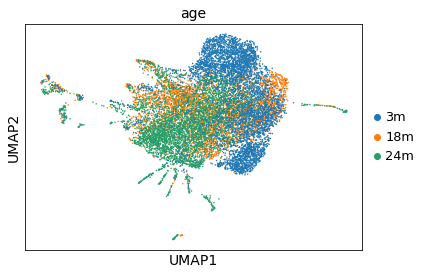

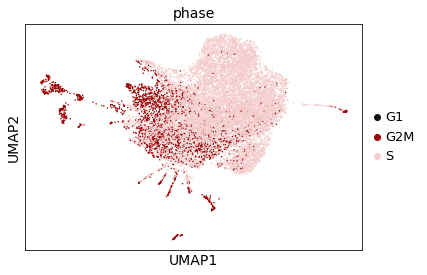

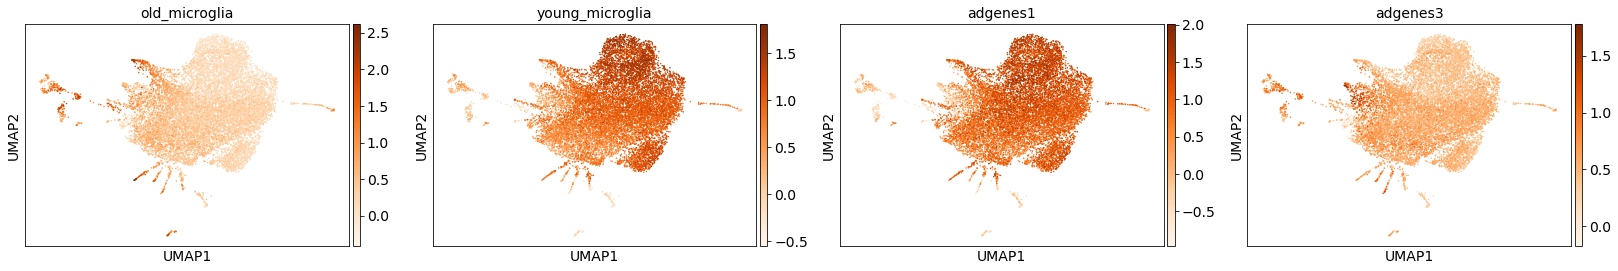

In [56]:
sc.pl.umap(clustered_brain_myeloid, color=['age'])
clustered_brain_myeloid.uns['phase_colors'] = ['#111111','#990000','#f4cccc']
sc.pl.umap(clustered_brain_myeloid, color=['phase'],save='_Amit_microglia.pfd')
sc.pl.umap(clustered_brain_myeloid, color=['old_microglia','young_microglia','adgenes1','adgenes3'],cmap='Oranges')



In [34]:
adgenes

array(['Cst7', 'Lpl', 'Clec7a', 'Itgax', 'Spp1', 'Igf1', 'Apoe', 'Axl',
       'Ank', 'Ch25h', 'Ctsd', 'Ccl3', 'Baiap2l2', 'Csf1', 'Fam20c',
       'Gnas', 'Ctsb', '5430435G22Rik', 'Lyz2', 'Cd63', 'Lgi2', 'Tyrobp',
       'Hpse', 'P2ry12', 'Mamdc2', 'Cox6a2', 'Ccl6', 'Gm1673', 'Cd9',
       'Ccl4', 'Ctsz', 'Tmem119', 'Fth1', 'B2m', 'Cx3cr1', 'Gusb',
       'Fabp3', 'Actr3b', 'H2-D1', 'Ctsl', 'Serpine2', 'Lilrb4', 'Selplg',
       'Cd52', 'Lgals3bp', 'Dkk2', 'Psat1', 'Cxcl14', 'Lox', 'Flt1',
       'Capg', 'Mif', 'Nceh1', 'Sulf2', 'Serinc3', 'Lyz1', 'Rps2', 'Npc2',
       'Etl4', 'Gm11428', 'Cd68', 'Rps28', 'Syngr1', 'Anxa5', 'Hif1a',
       'H2-K1', 'Atp1a3', 'Kcnj2', 'Hexa', 'Gpnmb', 'Cd34', 'Fabp5',
       'Ramp1', 'Myo1e', 'Cadm1', 'Ndufa1', 'Crlf2', 'Tpi1', 'Cox6a1',
       'Rplp2', 'Il4i1', 'Rpl18a', 'Pld3', 'Rps18', 'Rps24', 'Rpl37',
       'Rps21', 'Marcks', 'Slamf9', 'Tmem163', 'Trem2', 'Timp2', 'Aldoa',
       'Rps5', 'Rpl23', 'Myo5a', 'Gpr65', 'Rps20', 'Rpl10a', 'Grn',
      

# Case study: Kidney macrophages

In [3]:
kidney_13_vs_10 = pd.read_csv('./Fig4/droplet.Kidney.macrophage.rank_genes_13vs10.csv')
kidney_10_vs_13 = pd.read_csv('./Fig4/droplet.Kidney.macrophage.rank_genes_10vs13.csv')

kidney_10_vs_13.head()

,Unnamed: 0,score,logfoldchanges,pvals,pvals_adj
0,H2-Eb1,57.123486,3.938392,6.678586e-314,1.325165e-309
1,H2-Ab1,53.114357,3.513743,3.221223e-289,3.195775e-285
2,H2-Aa,50.880611,3.512559,1.551105e-273,6.155406e-270
3,Cd74,48.005177,2.582210,1.551714e-244,3.848638e-241
4,C1qa,46.840717,5.184548,1.029760e-241,2.043250e-238


In [2]:
kidney_13_vs_10['age'] = 'old'
kidney_10_vs_13['age'] = 'young'
kidney_macrophages = pd.concat([kidney_10_vs_13,kidney_13_vs_10],axis=0)
kidney_macrophages

In [5]:
adata = read_h5ad('/data/maca/maca-data-release-v4/tabula-muris-senis-droplet-processed-official-annotations.h5ad')
adata

AnnData object with n_obs × n_vars = 245389 × 20138 
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'cell_ontology_class_reannotated', 'n_counts', 'louvain', 'leiden'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'age_colors', 'leiden', 'leiden_colors', 'louvain', 'neighbors', 'pca', 'tissue_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

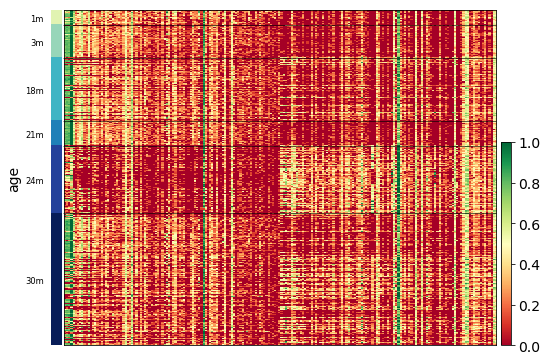

GridSpec(2, 4, height_ratios=[0, 6], width_ratios=[0.2, 8, 0, 0.2])

In [31]:
kidney = adata[adata.obs['tissue']=='Kidney']
sc.pl.heatmap(kidney[kidney.obs['cell_ontology_class_reannotated']=='macrophage'],
              list(kidney_macrophages['Unnamed: 0'].values),
              groupby='age',log=True,use_raw=True,dendrogram=False, 
              cmap='RdYlGn',standard_scale='obs',#show_gene_labels=True
             save = '_kidney_macrophages.pdf')

